In [1]:
## Notebook env: mirtud_env (mirtud_env kernel)
### This notebook analyzes how well the model in MAVE_trial.ipynb (and MAVE_trial.nbconvert.ipynb)
## learned the data by analyzing the pearson Rs for each cell between inputted raw data and 
## MAVE reconstructed output data
### The notebook also looks at stabilization of loss functions 

## loss_scalers = [100, 1, 0.1, 0.001]

%load_ext rpy2.ipython

In [36]:
%%R
library(ggplot2)
library(stringr)
library(tidyr)
library(ggpointdensity)

In [52]:
%%R
Loss <- read.csv('/home/ssobti/projects/mir_tud/output_data/mave_output/mave_trblsht/logs/training.log.2022-12-12_13049011.168634', sep ='\t')
colnames(Loss)[2] <- 'Total_Loss'
Loss$Recon_Loss <- str_sub(Loss$Recon_Loss, start = 8, end = 17)
Loss$KLD_Loss <- str_sub(Loss$KLD_Loss, start = 8, end = 13)
Loss$Classification_Loss <- str_sub(Loss$Classification_Loss, start = 8, end = 13)
Loss$Triplet_Loss <- str_sub(Loss$Triplet_Loss, start = 8, end = 13)
Loss[,3:6] <- apply(Loss[,3:6], 2, as.numeric)
Loss$Triplet_Loss[is.na(Loss$Triplet_Loss)] <- 0


Loss$Recon_Loss <- Loss$Recon_Loss/max(Loss$Recon_Loss)
Loss$KLD_Loss <- Loss$KLD_Loss/max(Loss$KLD_Loss)
Loss$Classification_Loss <- Loss$Classification_Loss/max(Loss$Classification_Loss)
Loss$Triplet_Loss <- Loss$Triplet_Loss/max(Loss$Triplet_Loss)


Individual_losses <- pivot_longer(Loss, cols = 3:6, names_to = 'Loss_type', values_to = 'Loss')


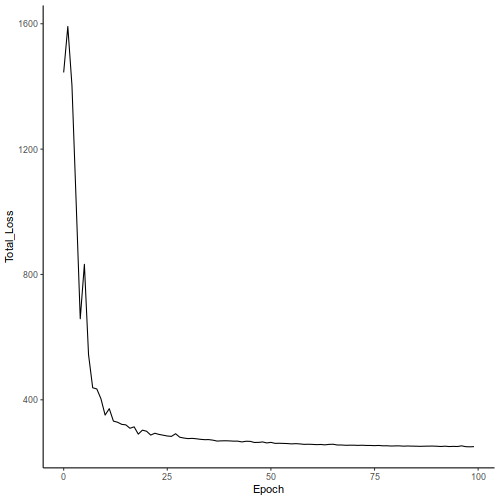

In [54]:
%%R -h 500 -w 500
Total_loss_plot <- ggplot(Loss, aes(Epoch, Total_Loss)) + geom_path() + theme_classic()
Total_loss_plot

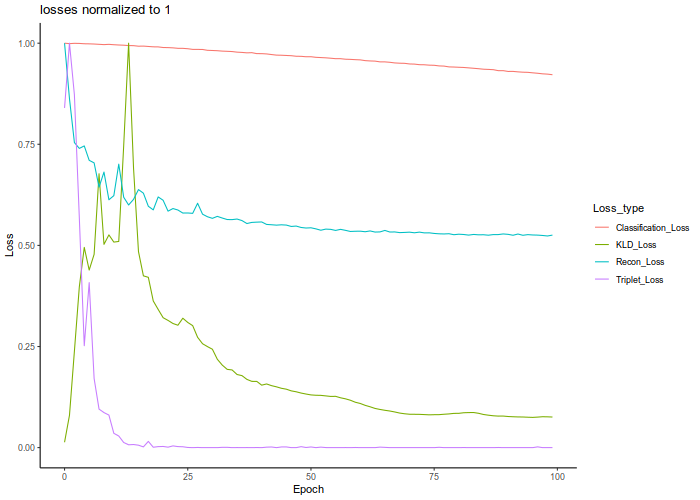

In [55]:
%%R -h 500 -w 700
Individual_loss_plot <- ggplot(Individual_losses, aes(Epoch, Loss, color = Loss_type)) + geom_path() + theme_classic() + ggtitle("losses normalized to 1")
Individual_loss_plot

In [19]:
%%R
UMAP_output <- read.csv("/home/ssobti/projects/mir_tud/output_data/mave_output/mave_trblsht/UMAP-OF-MU.tsv.gz", sep = '\t', row.names = 1)
head(UMAP_output)

                             UMAP1     UMAP2             guide
miR_2:CCCTCAATCCCAGGAC-1  5.380636  5.395479    hsa-miR-877-5p
miR_1:TCGAAGTCAGTGCGCT-1  5.502002  6.390927    hsa-miR-29b-3p
miR_2:CGCGTGAGTAGCACAG-1  9.160057  9.687579   hsa-miR-449c-5p
miR_2:TTGCGTCTCGCTAGCG-1 10.135584  8.513833 hsa-miR-219a-1-3p
miR_2:ACATGCAAGCGCCCAT-1  7.225802  4.481330    hsa-miR-204-5p
miR_3:CAGGGCTAGGCACGAT-1  7.993707 10.929865  hsa-miR-26a-1-3p


In [20]:
%%R
library(dplyr)
MAVE_latent_2dims <- read.csv("/home/ssobti/projects/mir_tud/output_data/mave_output/mave_trblsht/scMAVE_mu-matrix.tsv.gz", sep = '\t', row.names = 1)
MAVE_latent_2dims <- select(MAVE_latent_2dims, LV.mu.0, LV.mu.1)
MAVE_latent_2dims$guide <- UMAP_output$guide
head(MAVE_latent_2dims)

                            LV.mu.0      LV.mu.1             guide
miR_2:CCCTCAATCCCAGGAC-1 -0.3468941 -0.247518897    hsa-miR-877-5p
miR_1:TCGAAGTCAGTGCGCT-1  0.2398286  0.002981648    hsa-miR-29b-3p
miR_2:CGCGTGAGTAGCACAG-1  1.0008812  0.243875936   hsa-miR-449c-5p
miR_2:TTGCGTCTCGCTAGCG-1 -0.2369496  0.056869507 hsa-miR-219a-1-3p
miR_2:ACATGCAAGCGCCCAT-1 -0.4968942  0.409461886    hsa-miR-204-5p
miR_3:CAGGGCTAGGCACGAT-1  0.6435705  1.339759707  hsa-miR-26a-1-3p


In [21]:
%%R
guides = unique(MAVE_latent_2dims$guide)
tmp_df = as.data.frame(matrix(0, nrow = nrow(MAVE_latent_2dims), ncol = length(guides)))
colnames(tmp_df) = guides
for (i in 1:length(guides)){
    guide_cells = MAVE_latent_2dims$guide == guides[i]
    vec = MAVE_latent_2dims$guide
    vec[guide_cells] = 'Guide'
    vec[!guide_cells] = 'N/A'
    tmp_df[,i] <- vec
}
MAVE_latent_2dims = cbind(MAVE_latent_2dims, tmp_df)

In [22]:
%%R
guides = unique(UMAP_output$guide)
tmp_df = as.data.frame(matrix(0, nrow = nrow(UMAP_output), ncol = length(guides)))
colnames(tmp_df) = guides
for (i in 1:length(guides)){
    guide_cells = UMAP_output$guide == guides[i]
    vec = UMAP_output$guide
    vec[guide_cells] = 'Guide'
    vec[!guide_cells] = 'N/A'
    tmp_df[,i] <- vec
}
UMAP_output_2dims = cbind(UMAP_output, tmp_df)

In [23]:
%%R
print(paste(nrow(MAVE_latent_2dims), 'rows'))
print(paste(ncol(MAVE_latent_2dims), 'columns'))
head(MAVE_latent_2dims[, 1:5])

[1] "500 rows"
[1] "265 columns"
                            LV.mu.0      LV.mu.1             guide
miR_2:CCCTCAATCCCAGGAC-1 -0.3468941 -0.247518897    hsa-miR-877-5p
miR_1:TCGAAGTCAGTGCGCT-1  0.2398286  0.002981648    hsa-miR-29b-3p
miR_2:CGCGTGAGTAGCACAG-1  1.0008812  0.243875936   hsa-miR-449c-5p
miR_2:TTGCGTCTCGCTAGCG-1 -0.2369496  0.056869507 hsa-miR-219a-1-3p
miR_2:ACATGCAAGCGCCCAT-1 -0.4968942  0.409461886    hsa-miR-204-5p
miR_3:CAGGGCTAGGCACGAT-1  0.6435705  1.339759707  hsa-miR-26a-1-3p
                         hsa-miR-877-5p hsa-miR-29b-3p
miR_2:CCCTCAATCCCAGGAC-1          Guide            N/A
miR_1:TCGAAGTCAGTGCGCT-1            N/A          Guide
miR_2:CGCGTGAGTAGCACAG-1            N/A            N/A
miR_2:TTGCGTCTCGCTAGCG-1            N/A            N/A
miR_2:ACATGCAAGCGCCCAT-1            N/A            N/A
miR_3:CAGGGCTAGGCACGAT-1            N/A            N/A


In [24]:
%%R
UMAP_output[1:5,c(1,2)]

                             UMAP1    UMAP2
miR_2:CCCTCAATCCCAGGAC-1  5.380636 5.395479
miR_1:TCGAAGTCAGTGCGCT-1  5.502002 6.390927
miR_2:CGCGTGAGTAGCACAG-1  9.160057 9.687579
miR_2:TTGCGTCTCGCTAGCG-1 10.135584 8.513833
miR_2:ACATGCAAGCGCCCAT-1  7.225802 4.481330


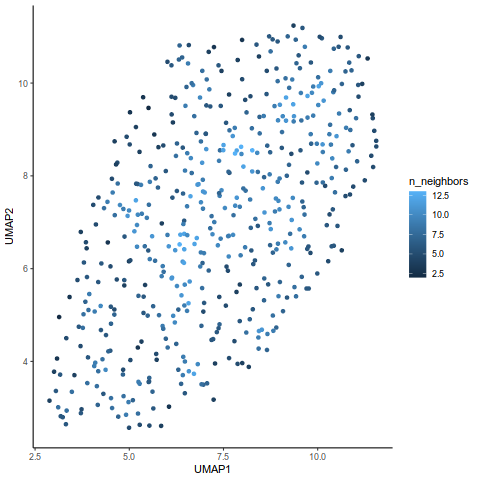

In [25]:
%%R
## density plot of cells plotted in UMAP1/UMAP2 space
library(ggplot2)
library(ggpointdensity)
library(stringr)
ggplot(UMAP_output, aes(UMAP1, UMAP2)) + geom_pointdensity() + theme_classic() +
xlab('UMAP1') + ylab('UMAP2')

In [26]:
%%R
MAVE_latent_2dims[1:5,1:5]

                            LV.mu.0      LV.mu.1             guide
miR_2:CCCTCAATCCCAGGAC-1 -0.3468941 -0.247518897    hsa-miR-877-5p
miR_1:TCGAAGTCAGTGCGCT-1  0.2398286  0.002981648    hsa-miR-29b-3p
miR_2:CGCGTGAGTAGCACAG-1  1.0008812  0.243875936   hsa-miR-449c-5p
miR_2:TTGCGTCTCGCTAGCG-1 -0.2369496  0.056869507 hsa-miR-219a-1-3p
miR_2:ACATGCAAGCGCCCAT-1 -0.4968942  0.409461886    hsa-miR-204-5p
                         hsa-miR-877-5p hsa-miR-29b-3p
miR_2:CCCTCAATCCCAGGAC-1          Guide            N/A
miR_1:TCGAAGTCAGTGCGCT-1            N/A          Guide
miR_2:CGCGTGAGTAGCACAG-1            N/A            N/A
miR_2:TTGCGTCTCGCTAGCG-1            N/A            N/A
miR_2:ACATGCAAGCGCCCAT-1            N/A            N/A


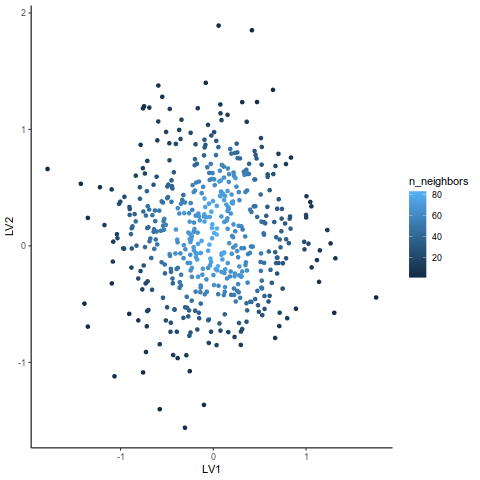

In [27]:
%%R
## density plot of cells plotted in LV.mu.0/LV.mu.1 space
library(ggplot2)
library(ggpointdensity)
library(stringr)
ggplot(MAVE_latent_2dims[,c(1,2)], aes(LV.mu.0, LV.mu.1)) + geom_pointdensity() + theme_classic() +
xlab('LV1') + ylab('LV2')


In [28]:
%%R
plts <- list()
for (i in 1:length(1:length(guides))){
    tmp <- MAVE_latent_2dims[,c(1,2,(i+3))]
    colnames(tmp)[3] <- 'Type'
    tmp <- tmp[order(tmp$Type, decreasing = TRUE),]
    if (str_sub(guides[i], start = 1, end = 6) == 'TuD_NC'){
        plts[[i]] <- ggplot(tmp, aes(LV.mu.0, LV.mu.1, color = Type)) + geom_point() + 
        theme_classic() + scale_color_manual(values = c('#39568CFF', 'gray95')) + theme(legend.position = 'none', plot.title = element_text(hjust = 0.5)) +
        ggtitle(guides[i]) + xlab('LV1') + ylab('LV2')
    } else {
        plts[[i]] <- ggplot(tmp, aes(LV.mu.0, LV.mu.1, color = Type)) + geom_point() + 
        theme_classic() + scale_color_manual(values = c('red', 'gray95')) + theme(legend.position = 'none', plot.title = element_text(hjust = 0.5)) +
        ggtitle(guides[i]) + xlab('LV1') + ylab('LV2')
    }
}


In [29]:
%%R
plts2 <- list()
for (i in 1:length(1:length(guides))){
    tmp <- UMAP_output_2dims[,c(1,2,(i+3))]
    colnames(tmp)[3] <- 'Type'
    tmp <- tmp[order(tmp$Type, decreasing = TRUE),]
    if (str_sub(guides[i], start = 1, end = 6) == 'TuD_NC'){
        plts2[[i]] <- ggplot(tmp, aes(UMAP1, UMAP2, color = Type)) + geom_point() + 
        theme_classic() + scale_color_manual(values = c('#39568CFF', 'gray95')) + theme(legend.position = 'none', plot.title = element_text(hjust = 0.5)) +
        ggtitle(guides[i]) + xlab('UMAP1') + ylab('UMAP2')
    } else {
        plts2[[i]] <- ggplot(tmp, aes(UMAP1, UMAP2, color = Type)) + geom_point() + 
        theme_classic() + scale_color_manual(values = c('red', 'gray95')) + theme(legend.position = 'none', plot.title = element_text(hjust = 0.5)) +
        ggtitle(guides[i]) + xlab('UMAP1') + ylab('UMAP2')
    }
}


In [30]:
%%R
library(ggpubr)
umap_plts <- rep(list('empty'), ceiling(length(plts2)/25))
for (i in 1:ceiling(length(plts2)/25)){
    umap_plts[[i]] <- ggarrange(plotlist = plts2[(25*(i-1)+1):(25*i)], ncol = 5, nrow = 5, legend = 'none')
}

In [31]:
%%R
library(ggpubr)
latent_plts <- rep(list('empty'), ceiling(length(plts)/25))
for (i in 1:ceiling(length(plts)/25)){
    latent_plts[[i]] <- ggarrange(plotlist = plts[(25*(i-1)+1):(25*i)], ncol = 5, nrow = 5, legend = 'none')
}

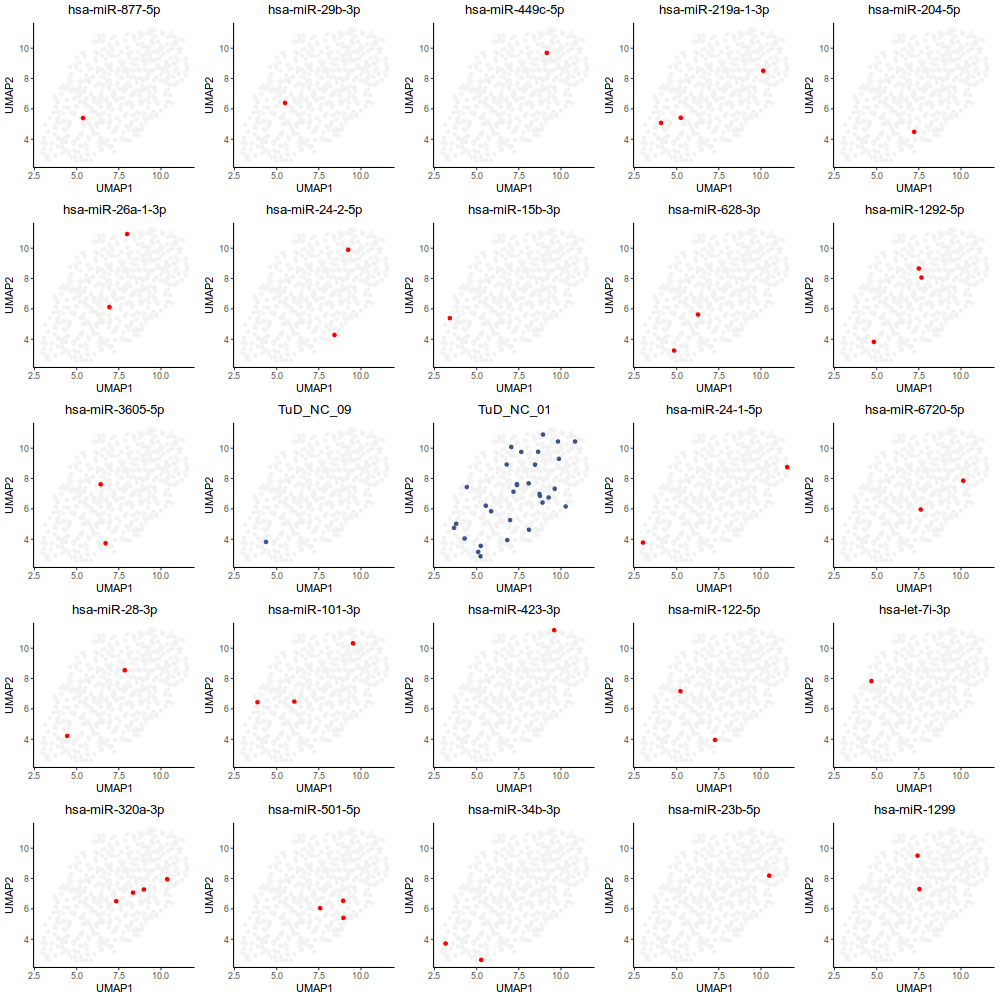

In [32]:
%%R -w 1000 -h 1000
## non-targeting control guides are blue and targeting guides are red
umap_plts[[1]]

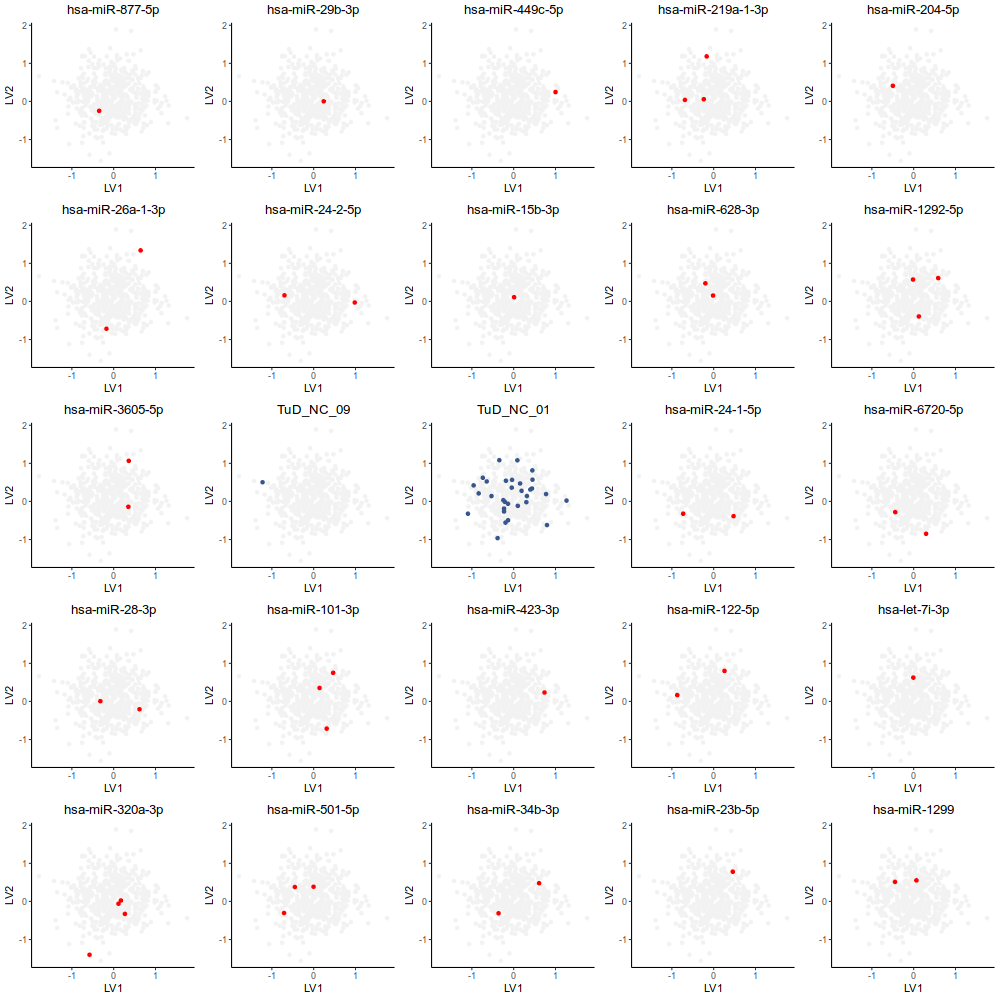

In [33]:
%%R -w 1000 -h 1000
## non-targeting control guides are blue and targeting guides are red
latent_plts[[1]]